### Load dataset and get overview statistics

id - policy id. not to be used in modelling apparently.

In [2]:
import pandas as pd
import pprint

filepath = 'train.csv'
df = pd.read_csv(filepath)
pp = pprint.PrettyPrinter()

print("Overview of columns: (first row)")
pp.pprint(df.head(1).T)


Overview of columns: (first row)
                                       0
id                                110936
perc_premium_paid_by_cash_credit   0.429
age_in_days                        12058
Income                            355060
Count_3-6_months_late                  0
Count_6-12_months_late                 0
Count_more_than_12_months_late         0
application_underwriting_score     99.02
no_of_premiums_paid                   13
sourcing_channel                       C
residence_area_type                Urban
premium                             3300
renewal                                1


### Summary statistics and plots for certain variables

First, preprocessing for the data. convert age to years.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

categorical_vars = ['residence_area_type','sourcing_channel']
numerical_vars = list(set(list(df.columns)) - set(categorical_vars))

sub_df = df[numerical_vars]
sub_df['age_in_days'] = sub_df['age_in_days'] // 365

/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Plot all numerical variables as histograms

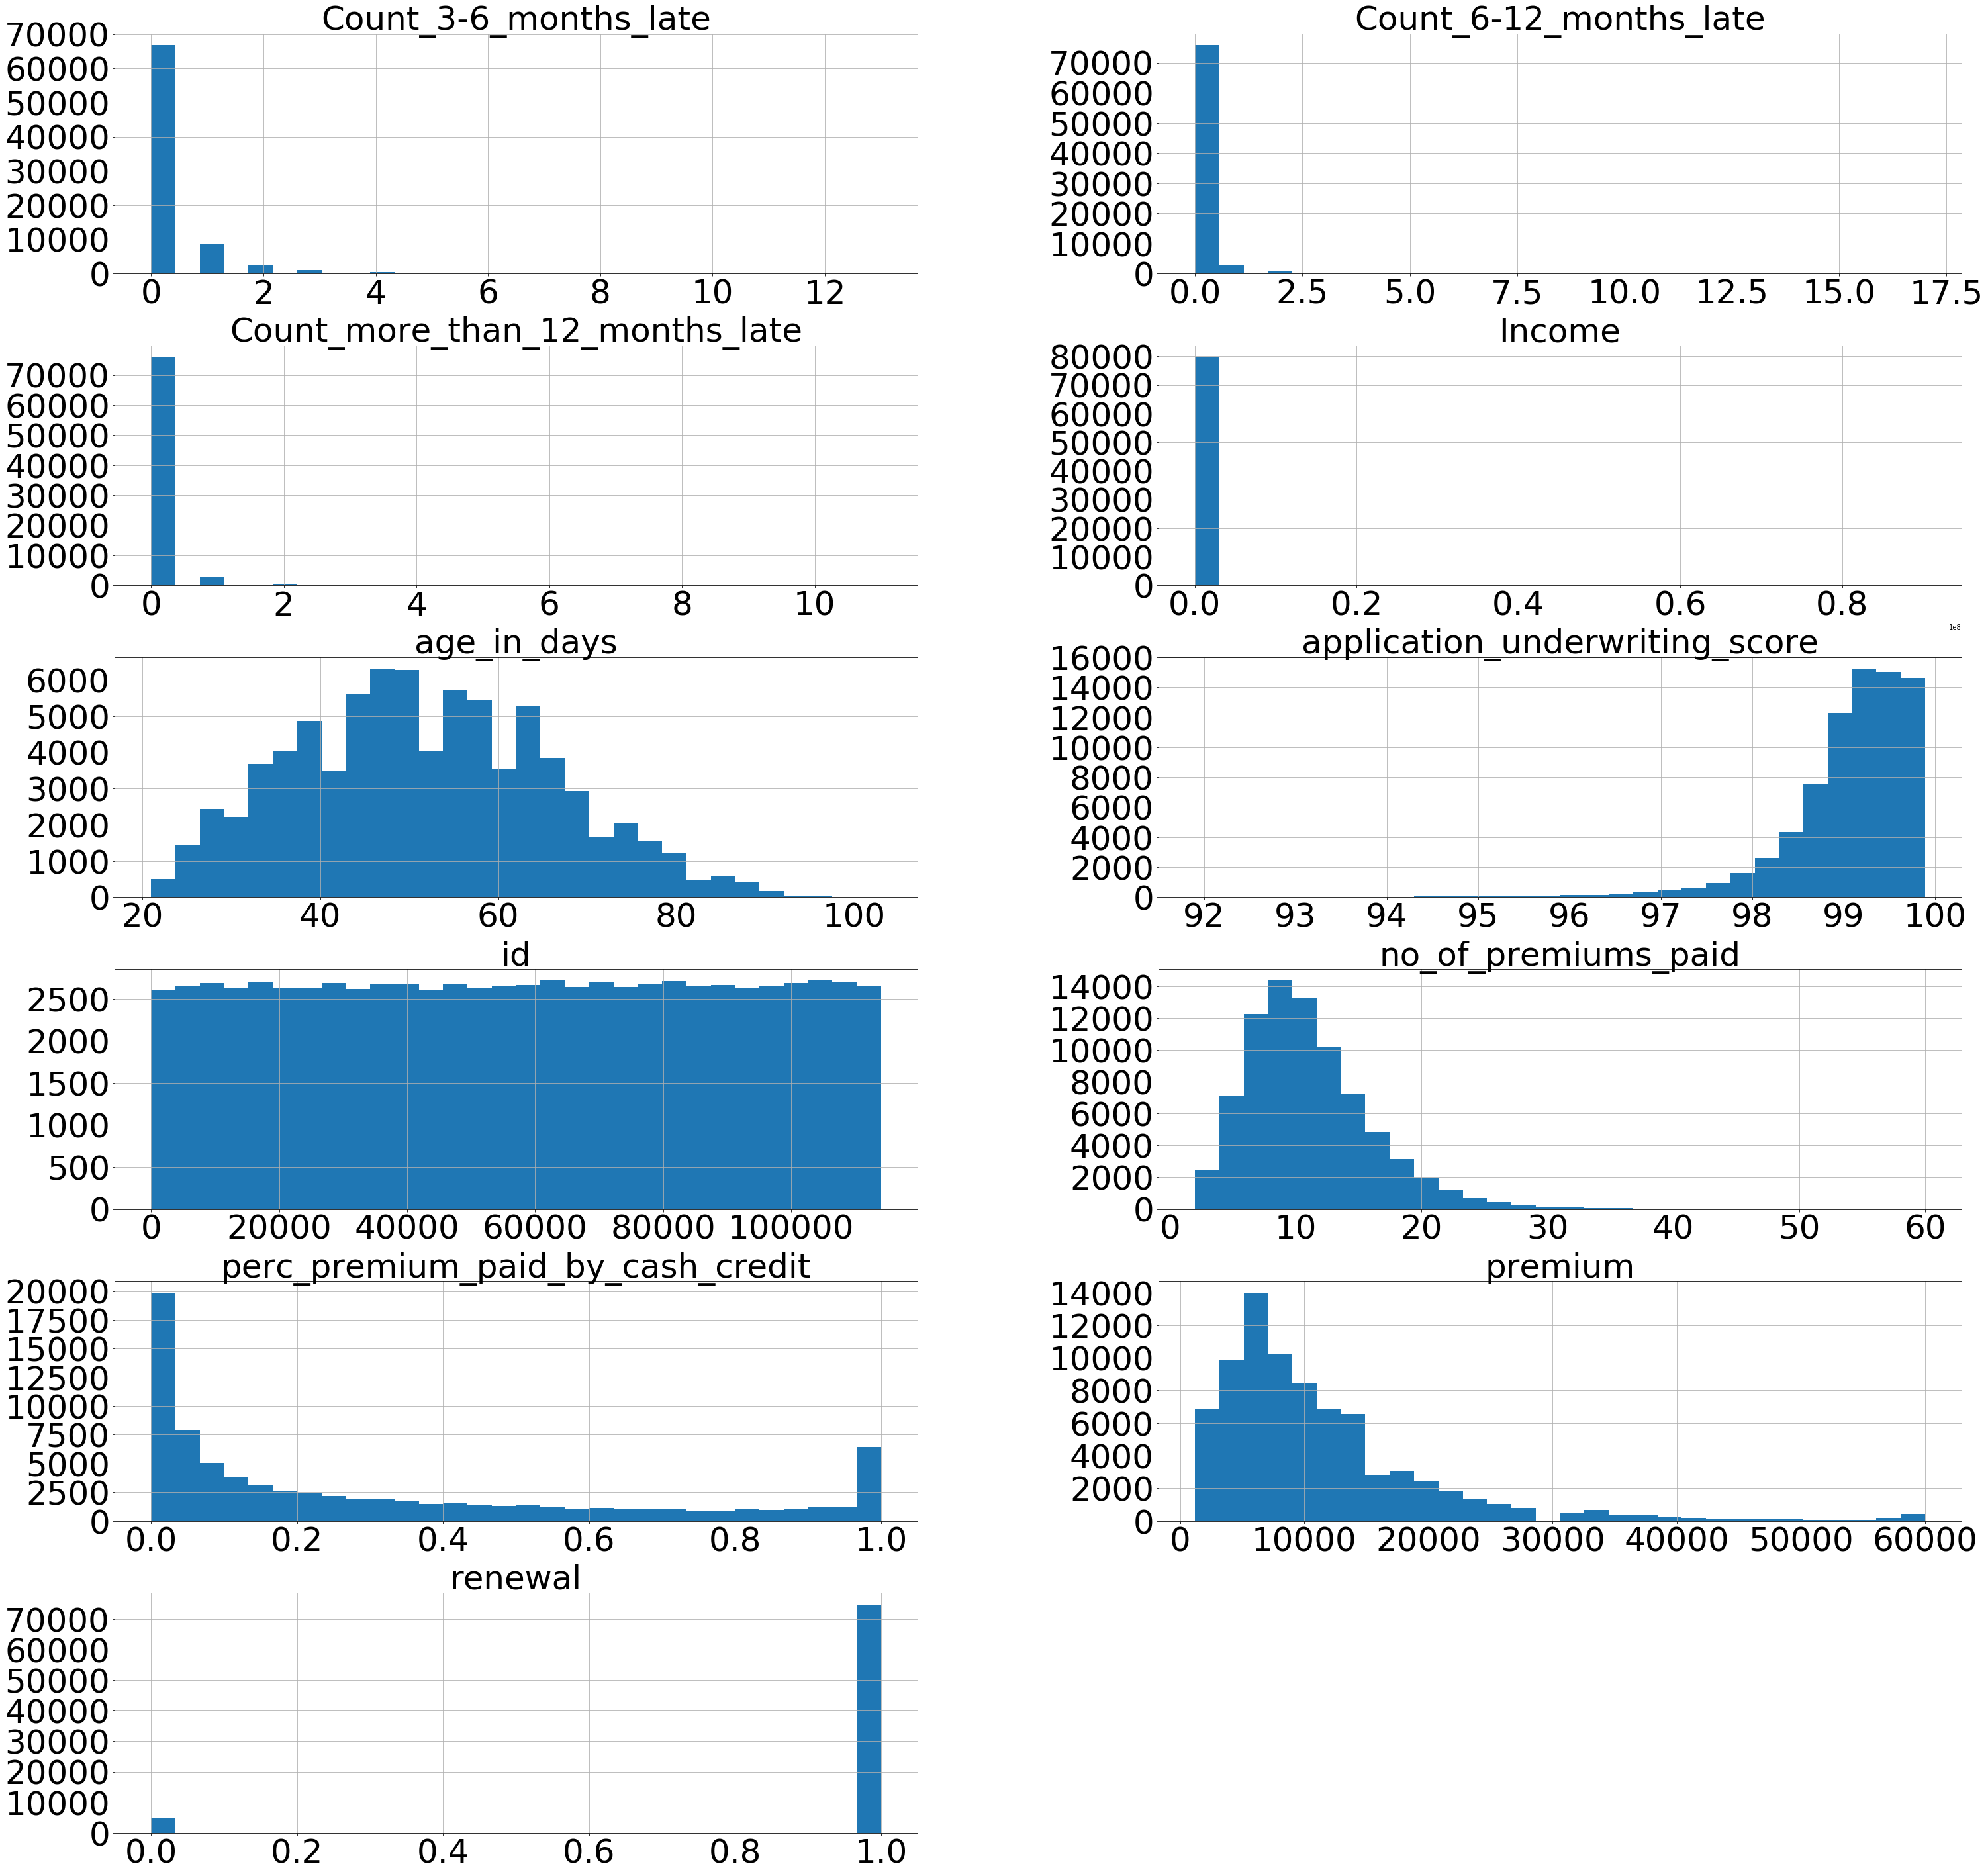

In [4]:
num_cols = 2 #2 easy to see
num_rows = len(numerical_vars) // 2 + 1

fig = sub_df.hist(layout = (num_rows,num_cols), 
                    bins=30,
                    figsize=(50,50),
                   ylabelsize=50,
                   xlabelsize=50)
titles = [x.title.set_size(50) for x in fig.ravel()] # title size hack


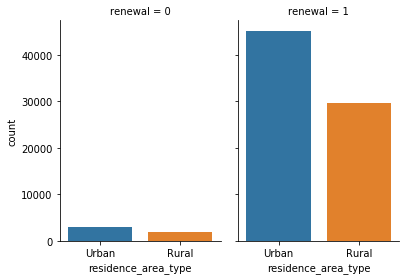

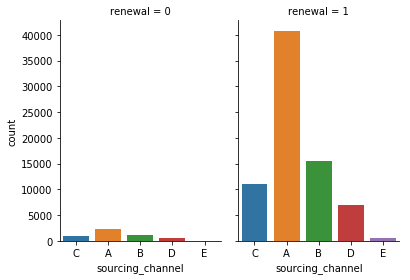

In [5]:
for i,entry in enumerate(categorical_vars):
    g = sns.catplot(x=entry, col="renewal",
                 data=df, kind="count",
                 height=4, aspect=.7)

#### Generate correlation matrix and statistics about renewal

Renewal Distribution:
1    74855
0     4998
Name: renewal, dtype: int64

Correlation Matrix Pic


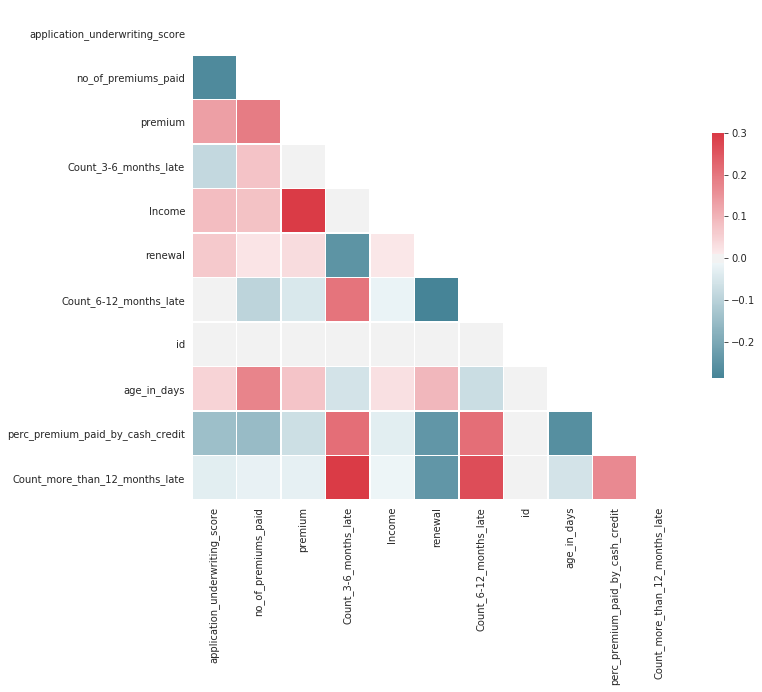

In [6]:
import numpy as np

## Function to generate heatmap of correlations - https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def corr_matrix_generator(corr,drop_duplicates = True):
    if drop_duplicates:    
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
    sns.set_style(style = 'white')
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    if drop_duplicates:
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    else:
        sns.heatmap(corr, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        
        

    
corr = sub_df.corr()

print("Renewal Distribution:")
print(sub_df['renewal'].value_counts())
print("\nCorrelation Matrix Pic")
corr_matrix_generator(corr)


#### Key / Interesting points:

1) The distribution for the target variable is highly imbalanced, with most people renewing.

    --> renewals weak -ly correlated with being late (makes sense)
    --> weak +vely correlated income,score,premium,num_premiums paid
   

2) Premiums are positively skewed

3) Most people overwhelmingly pay by cash or credit. Few inbetween - not say important.

### Test if train and test data come from the same distribution.

In [32]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn import metrics,cross_validation
from matplotlib import pyplot as plt
import itertools
import numpy as np
from sklearn.cross_validation import train_test_split

test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
train_df.drop('renewal',inplace=True,axis=1)
assert(list(test_df.columns) ==  list(train_df.columns))

train_df['col'] = 0
test_df['col'] = 1

combined_df = train_df.append(test_df)
combined_df = combined_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
print(len(combined_df))
print(combined_df.head(1).T)


combined_df = dummy_encode(combined_df)
combined_df = combined_df.drop('id',axis=1)

114077
                                       0
id                                 52486
perc_premium_paid_by_cash_credit   0.859
age_in_days                        13520
Income                            195120
Count_3-6_months_late                  0
Count_6-12_months_late                 0
Count_more_than_12_months_late         0
application_underwriting_score     97.78
no_of_premiums_paid                   19
sourcing_channel                       C
residence_area_type                Rural
premium                            13800
col                                    0


In [37]:
## helper functions for quick modelling

def dummy_encode(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df


def splitTrainTest(dataset,target,test_size=0.20):
    trainX,trainY,testX,testY = train_test_split(dataset,target, 
                                                 test_size=test_size,stratify=target)
    return trainX,trainY,testX,testY

def accuracyChecker(target,predicted):
    accuracy = metrics.accuracy_score(target,predicted)
    confMat = metrics.confusion_matrix(target,predicted)
    print('Cross val accuracy: '+str(accuracy))
    print('Confusion Matrix:')
    print(confMat)
    

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


clf = xgb.XGBClassifier(max_depth = 8,n_estimators=63,nthread=8,
                            silent=1,objective= 'binary:logistic',learning_rate=0.08)

dataset = combined_df.drop(['col'],axis=1).values
target = combined_df['col'].values


from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.metrics import roc_auc_score as AUC
predictions = np.zeros(target.shape) #creating an empty prediction array

skf = SKF(n_splits=10, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(dataset, target)):
    X_train, X_test = dataset[train_idx], dataset[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1] #calculating the probability
    predictions[test_idx] = probs

print("ROC-AUC for train and test distributions:", AUC(target, predictions))


ROC-AUC for train and test distributions: 0.4993065955294654


ROC about 50, so train and test are verified to be from same distributions